<a href="https://colab.research.google.com/github/geo-tp/Keras-Colaboratory-Models/blob/main/visualize_convnets_heatmaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualize convnets heatmap

##Dataset

In [ ]:
# DATASET & PREPROCESSING

from tensorflow import keras
from tensorflow.keras.applications.xception import preprocess_input
import numpy as np

img_path = keras.utils.get_file(
    "Y7hrS93.jpeg", "https://i.imgur.com/Y7hrS93.jpeg"
)

# Prepare image
img_size = (299, 299)
img = keras.preprocessing.image.load_img(img_path, target_size=img_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)


##Model

In [ ]:
# MODEL DEFINITION

from tensorflow.keras.applications.xception import Xception

model = Xception(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

##Prediction

In [ ]:
# PREDICTION

from tensorflow.keras.applications.xception import decode_predictions

preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

1/1 [==============================] - 1s 1s/step
Predicted: [('n02093991', 'Irish_terrier', 6.692013)]


##Visualizing Heatmap

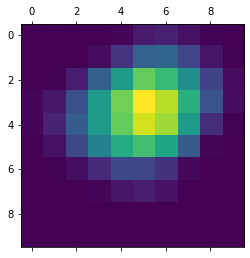

In [ ]:
# VISUALIZE HEATMAP

import tensorflow as tf
import matplotlib.pyplot as plt


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()


last_conv_layer_name = "block14_sepconv2_act"
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

plt.matshow(heatmap)
plt.show()


## Visualizing Heatmap On Image

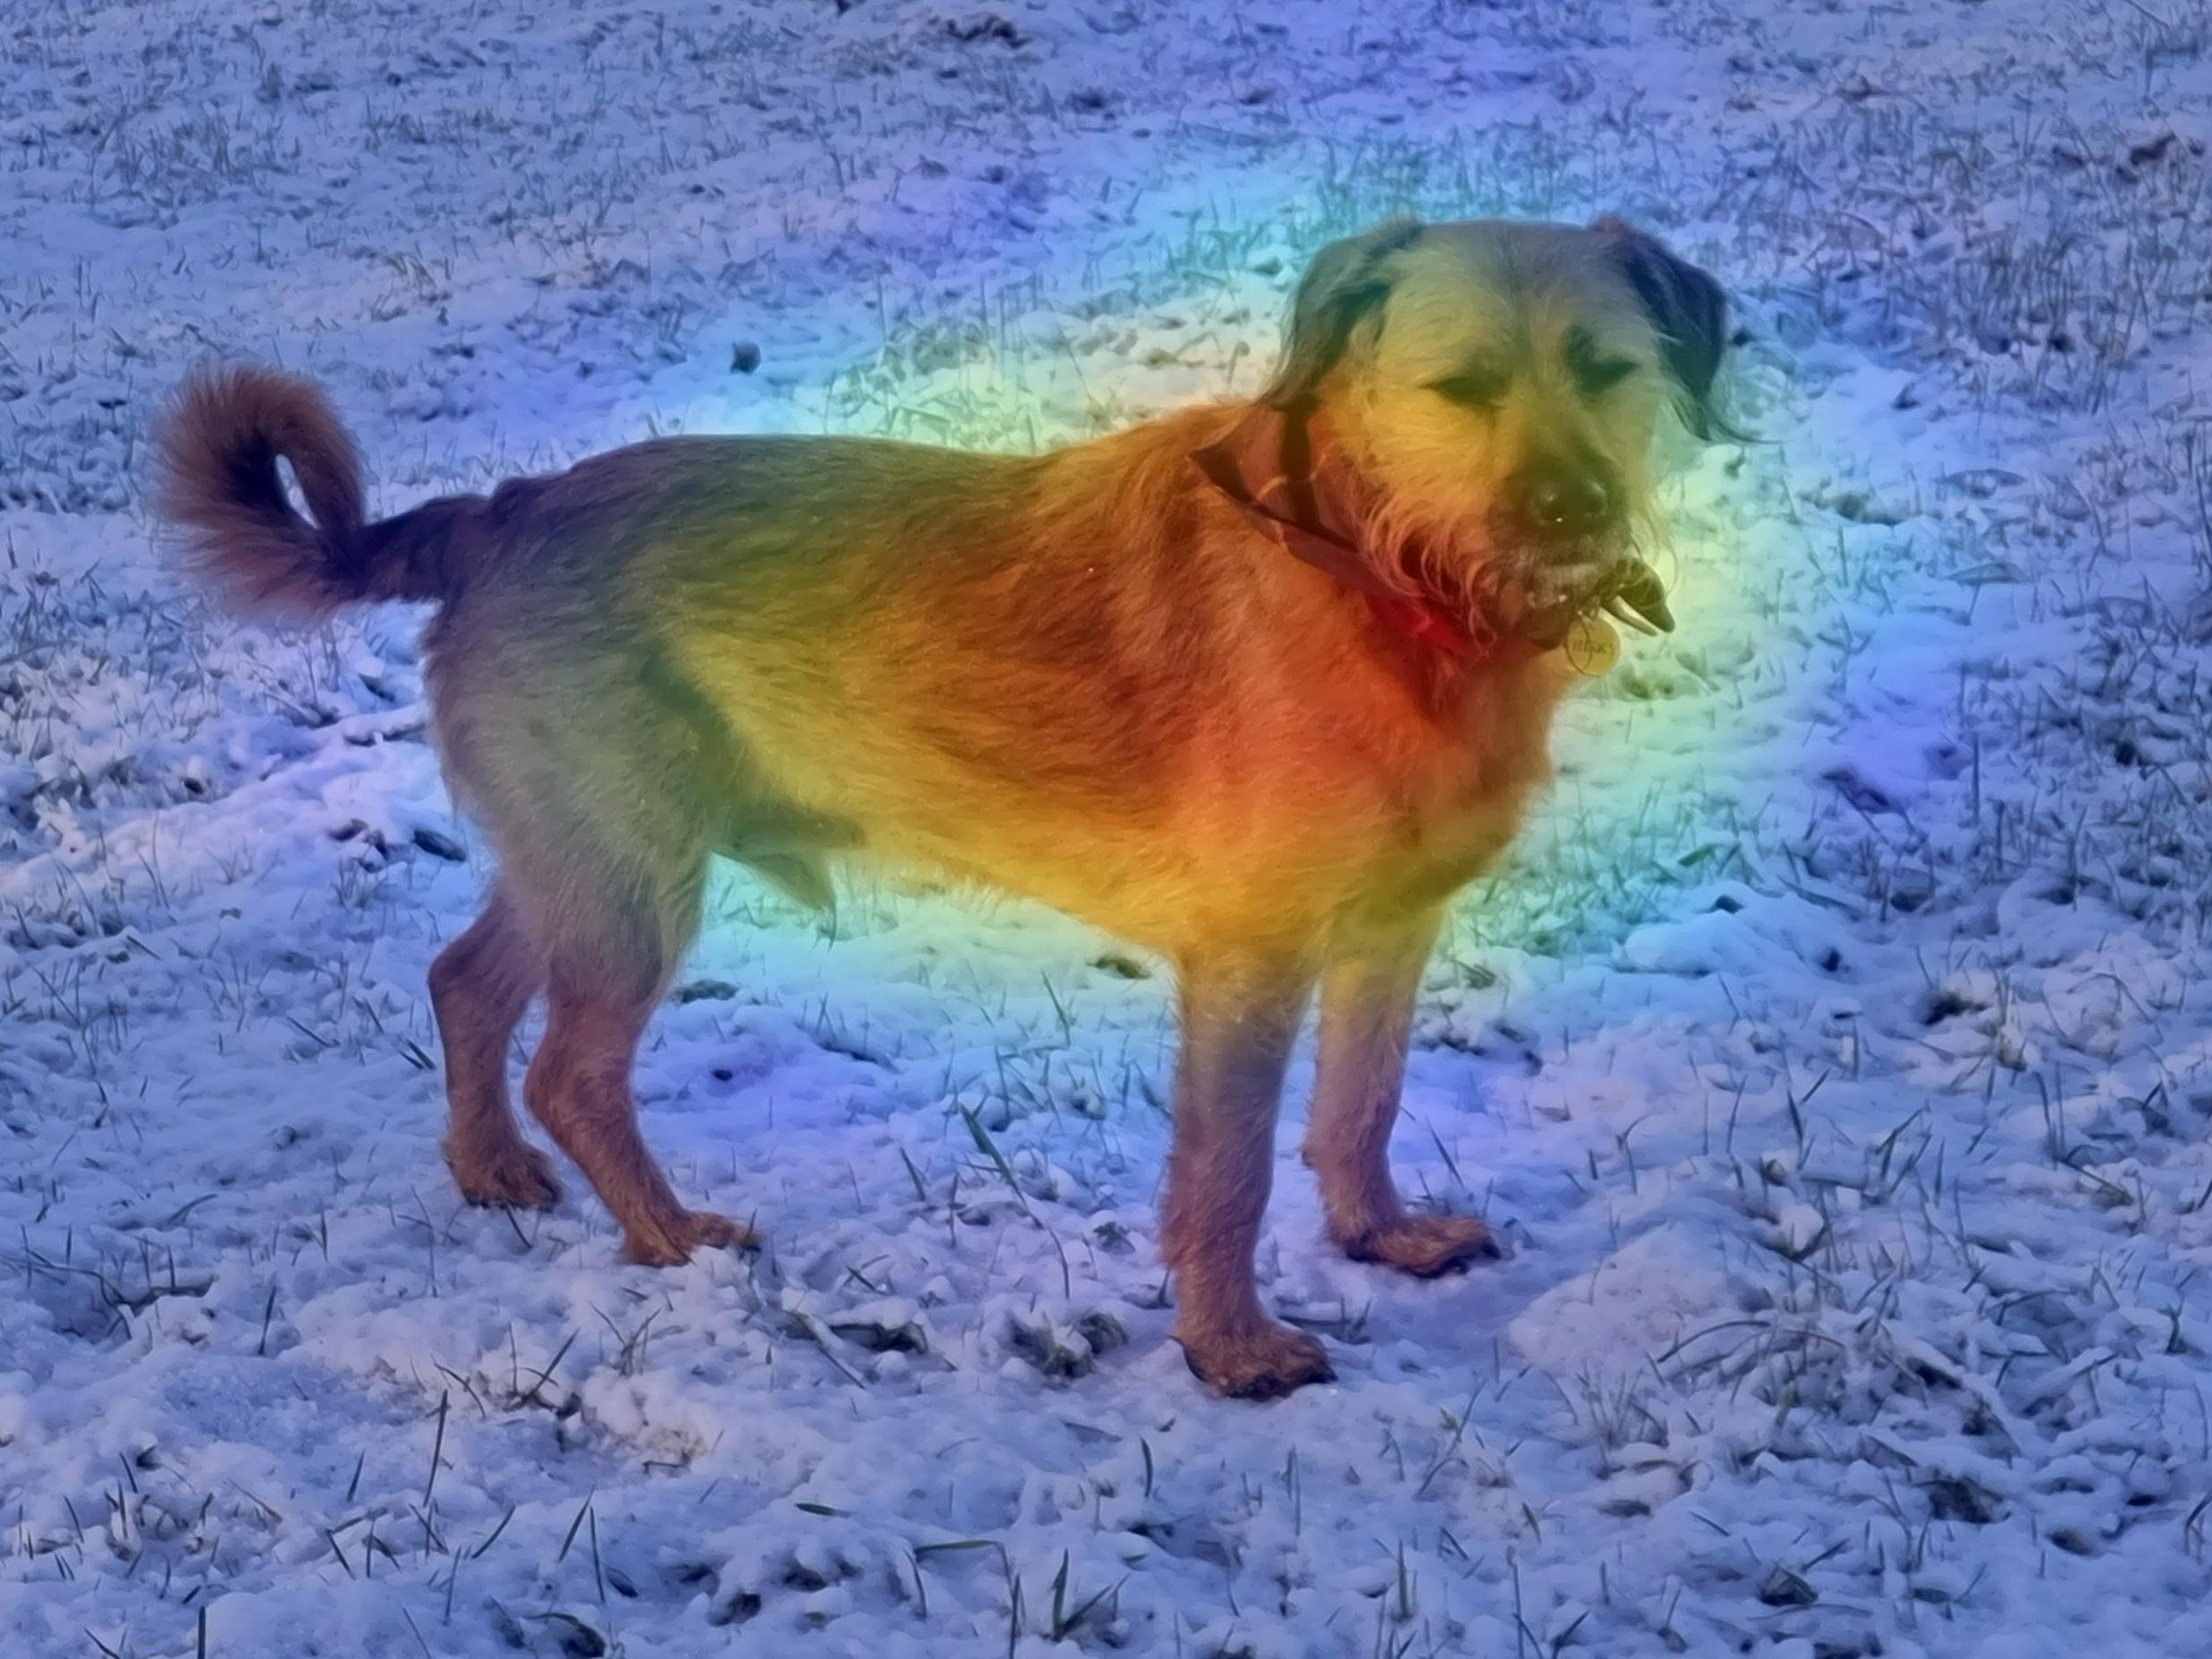

In [ ]:
# VISUALIZE HEATMAP ON IMAGE

import matplotlib.cm as cm
from IPython.display import Image, display


def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)